# Chemical Propeties 
Here, we will evaluate the quantity and some chemical properties of the generated PKA compounds:
* Chirality
* Quantity
* (HYDE) binding affinity
* Ro5 and Vebers properties

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import utils_eval
from IPython.core.display import HTML
from kinfraglib import utils
from rdkit import Chem
from rdkit.Chem import QED, AllChem, Descriptors, Draw, Lipinski, PandasTools

PandasTools.RenderImagesInAllDataFrames(images=True)

Read molecules to dataframe

,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,BIOSOLVEIT.DOCKING_SCORE,filtered,num_fragments,inchi,has_no_chiral_centre,binding_affinity
0,,0.056344,5.598103,1.78280,326.465,54.28,"{'AP': 288, 'SE': 63}",C[NH+]1CCC(c2ccc(NCCCNc3ccccn3)nc2)CC1,"{'AP': 'CCCNc1ccccn1', 'SE': '[54*]Nc1ccc(C2CC...","{'AP': '[6*]c1ccnc(NCCC[59*])c1', 'SE': 'C[NH+...",429.86,1,2,InChI=1S/C19H27N5/c1-24-13-8-16(9-14-24)17-6-7...,True,2.827224
1,,0.131869,13.102000,0.61940,324.406,75.11,"{'AP': 133, 'SE': 285}",CNC(=O)C[NH+]1CCC(c2cnc3[nH]c4cnccc4c3c2)CC1,"{'AP': 'c1cnc2[nH]c3cnccc3c2c1', 'SE': '[27*]C...","{'AP': '[1*]c1cc2c(cn1)[nH]c1ncc([21*])cc12', ...",-29.47,1,2,InChI=1S/C18H21N5O/c1-19-17(24)11-23-6-3-12(4-...,True,6.616935
2,,0.153319,15.233179,0.22440,324.430,74.65,"{'AP': 410, 'SE': 352}",CC(c1ccnc(Nc2ccc3cc[nH]c3n2)c1)[NH+]1CC[NH2+]CC1,"{'AP': 'Nc1ccc2cc[nH]c2n1', 'SE': '[6*]N1CC[NH...","{'AP': '[30*]Nc1cc([46*])c2cc[nH]c2n1', 'SE': ...",-21.60,1,2,InChI=1S/C18H22N6/c1-13(24-10-8-19-9-11-24)15-...,False,7.693249
3,,0.202910,20.160317,1.20200,352.436,76.34,"{'AP': 289, 'SE': 64}",COc1cc2nccc(O)c2cc1-c1ccc(N2CC[NH2+]CC2C)c[nH+]1,"{'AP': 'COc1ccc2c(O)ccnc2c1', 'SE': '[29*]c1cc...","{'AP': '[19*]c1cc2c(O[25*])ccnc2cc1OC', 'SE': ...",356.53,1,2,InChI=1S/C20H22N4O2/c1-13-11-21-7-8-24(13)14-3...,False,10.181613
4,,0.210052,20.869897,2.74282,340.404,94.92,"{'AP': 133, 'SE': 10}",Cc1nc(C(C)(O)CO)sc1-c1cnc2[nH]c3cnccc3c2c1,"{'AP': 'c1cnc2[nH]c3cnccc3c2c1', 'SE': '[5*]c1...","{'AP': '[1*]c1cc2c(cn1)[nH]c1ncc([21*])cc12', ...",-24.89,1,2,"InChI=1S/C17H16N4O2S/c1-9-14(24-16(20-9)17(2,2...",False,10.539975

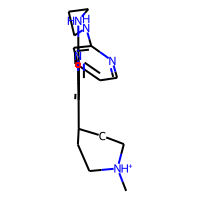
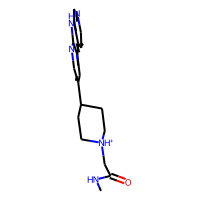
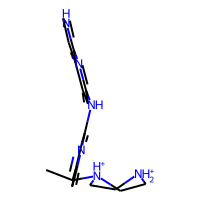
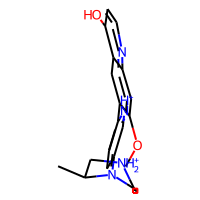
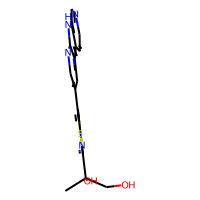

In [49]:
# read data
data = utils_eval.read_mols('../results_5l4q_rerun/5l4q/results.sdf')
data['inchi'] = data.apply(lambda x: Chem.MolToInchi(utils.standardize_mol(x.ROMol)), axis=1)
data['has_no_chiral_centre'] = data.apply(lambda x: len(Chem.FindMolChiralCenters(utils.standardize_mol(x.ROMol), includeUnassigned=True, useLegacyImplementation=False)) == 0, axis=1)
data['binding_affinity'] = data.apply(lambda x: (x['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM]'] + x['BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM]'])/2, axis=1)

HTML(data.head().to_html(notebook=True))

## Chirality
Compounds with a chiral centre are unfavoured regarding TODO. Here, we will determine these ligands.

In [50]:
print(f"Compounds with no chiral centre: {sum(data['has_no_chiral_centre'])}")

Compounds with no chiral centre: 59852


,ROMol,BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_LOWER_BOUNDARY [nM],BIOSOLVEIT.HYDE_ESTIMATED_AFFINITY_UPPER_BOUNDARY [nM],BIOSOLVEIT.LOGP,BIOSOLVEIT.MOLECULAR_WEIGHT,BIOSOLVEIT.TPSA,fragment_ids,smiles_ligand,smiles_fragments_dummy,smiles_fragments,BIOSOLVEIT.DOCKING_SCORE,filtered,num_fragments,inchi,has_no_chiral_centre,binding_affinity
0,,0.056344,5.598103,1.7828,326.465,54.28,"{'AP': 288, 'SE': 63}",C[NH+]1CCC(c2ccc(NCCCNc3ccccn3)nc2)CC1,"{'AP': 'CCCNc1ccccn1', 'SE': '[54*]Nc1ccc(C2CC...","{'AP': '[6*]c1ccnc(NCCC[59*])c1', 'SE': 'C[NH+...",429.86,1,2,InChI=1S/C19H27N5/c1-24-13-8-16(9-14-24)17-6-7...,True,2.827224
1,,0.131869,13.102000,0.6194,324.406,75.11,"{'AP': 133, 'SE': 285}",CNC(=O)C[NH+]1CCC(c2cnc3[nH]c4cnccc4c3c2)CC1,"{'AP': 'c1cnc2[nH]c3cnccc3c2c1', 'SE': '[27*]C...","{'AP': '[1*]c1cc2c(cn1)[nH]c1ncc([21*])cc12', ...",-29.47,1,2,InChI=1S/C18H21N5O/c1-19-17(24)11-23-6-3-12(4-...,True,6.616935
2,,0.236084,23.456307,4.8008,384.437,64.96,"{'AP': 133, 'SE': 143}",COc1ccc(OC)c(-c2cc(-c3cnc4[nH]c5cnccc5c4c3)n(C...,"{'AP': 'c1cnc2[nH]c3cnccc3c2c1', 'SE': '[30*]c...","{'AP': '[1*]c1cc2c(cn1)[nH]c1ncc([21*])cc12', ...",-24.29,1,2,InChI=1S/C23H20N4O2/c1-27-13-15(18-10-16(28-2)...,True,11.846196
3,,0.248610,24.700886,1.9745,374.470,74.17,"{'AP': 133, 'SE': 56}",CC[NH+]1CCN(c2ccc(Nc3cnc4[nH]c5cnccc5c4c3)nc2)CC1,"{'AP': 'c1cnc2[nH]c3cnccc3c2c1', 'SE': '*Nc1cc...","{'AP': '[1*]c1cc2c(cn1)[nH]c1ncc([21*])cc12', ...",-27.23,1,2,InChI=1S/C21H23N7/c1-2-27-7-9-28(10-8-27)16-3-...,True,12.474748
4,,0.268739,26.700760,0.5598,428.537,93.80,"{'AP': 143, 'SE': 252}",C[NH+]1CC[NH+](Cc2ccc3c(-c4cnc(N)c(-c5ccccc5)c...,"{'AP': 'Nc1ncccc1-c1ccccc1', 'SE': '[7*]c1nn([...","{'AP': '[3*]c1ccc(-c2cc([15*])cnc2N)cc1', 'SE'...",-11.23,1,2,InChI=1S/C25H26N6O/c1-30-9-11-31(12-10-30)16-1...,True,13.484749

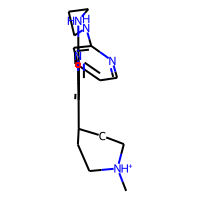
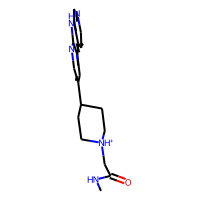
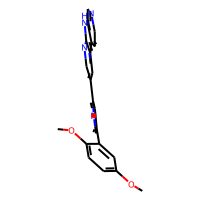
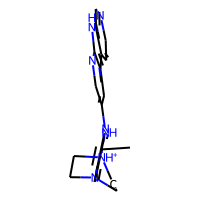
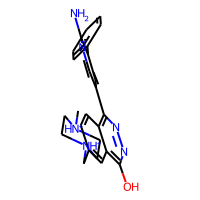

In [51]:
data_without_chiral_centre = data[data['has_no_chiral_centre']].reset_index(drop=True)
HTML(data_without_chiral_centre.head().to_html(notebook=True))

## Quantities

In [52]:
print(f"Total number of compounds: {data.index.size}")
print(f"Post-filter --->")
data_post_filtered = data[data['binding_affinity'] <= 1000].copy() 
print(f"Number of compounds with binding affinity higher than or equal 1000 nM: {data_post_filtered.index.size}")
for unique_val in pd.unique(data_post_filtered['num_fragments']):
    print(f"Number of ligands comprising {unique_val} fragments: {sum(x == unique_val for x in data_post_filtered['num_fragments'])}")

print(f'Number of compounds with bindinda affinity less than 100nM: {sum(data["binding_affinity"] < 100)}')

Total number of compounds: 81848
Post-filter --->
Number of compounds with binding affinity higher than or equal 1000 nM: 18158
Number of ligands comprising 2 fragments: 1441
Number of ligands comprising 3 fragments: 16717
Number of compounds with bindinda affinity less than 100nM: 7103


In [53]:
print(f'Removed {100-data_post_filtered.index.size/data.index.size * 100} compounds (noise)')

Removed 77.8149740983286 compounds (noise)


In [54]:
data_post_filtered = data_post_filtered.sort_values(['binding_affinity']).reset_index(drop=True)

In [55]:
with Chem.SDWriter('../results_5n1f_25_02/top15.sdf') as w:
  for m in data_post_filtered.ROMol[:15]:
    w.write(m)

## Molecular properties

### Affinity

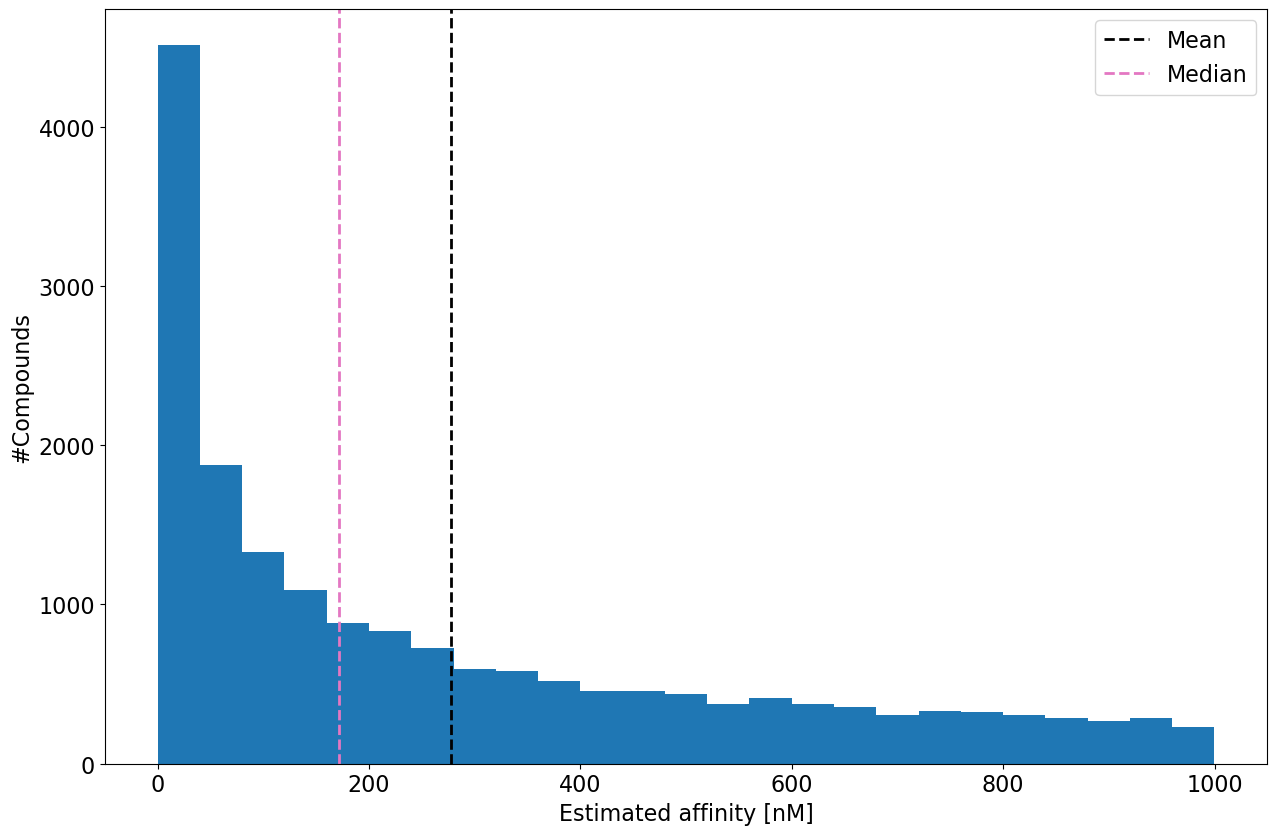

In [56]:
plt.figure(figsize=(15, 9.8))
plt.hist(data_post_filtered.binding_affinity, bins=25)
plt.ylabel("#Compounds", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Estimated affinity [nM]', fontsize=16)
mean_line = plt.axvline(data_post_filtered.binding_affinity.mean(), color='k', linestyle='dashed', linewidth=2, label="Mean")
median_line = plt.axvline(data_post_filtered.binding_affinity.median(), color='tab:pink', linestyle='dashed', linewidth=2, label="Median")
plt.legend(handles = [mean_line, median_line], fontsize=16)
plt.show()

In [57]:
print(f"Statistics of binding affinity (post-filtered): \n{data_post_filtered['binding_affinity'].describe()}")
print(f"Estimated binding affinity [nM] median: {data_post_filtered['binding_affinity'].median()}")

Statistics of binding affinity (post-filtered): 
count    18158.000000
mean       277.518929
std        280.458618
min          0.021100
25%         40.603734
50%        171.268515
75%        458.463702
max        999.924213
Name: binding_affinity, dtype: float64
Estimated binding affinity [nM] median: 171.26851525


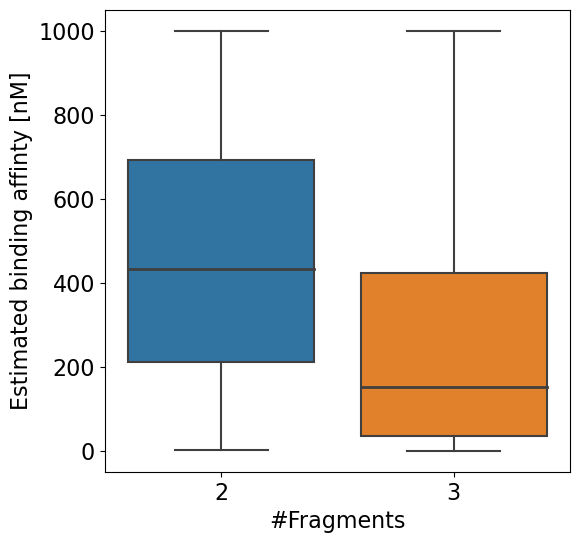

In [58]:
# binding affinity per subpocket
plt.figure(figsize=(6, 6))

bp = sns.boxplot(
x="num_fragments",
y='binding_affinity',
data=data_post_filtered,
medianprops={"linewidth": 2, "linestyle": "-"},
)
plt.ylabel("Estimated binding affinty [nM]", fontsize=16)
plt.xlabel("#Fragments", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

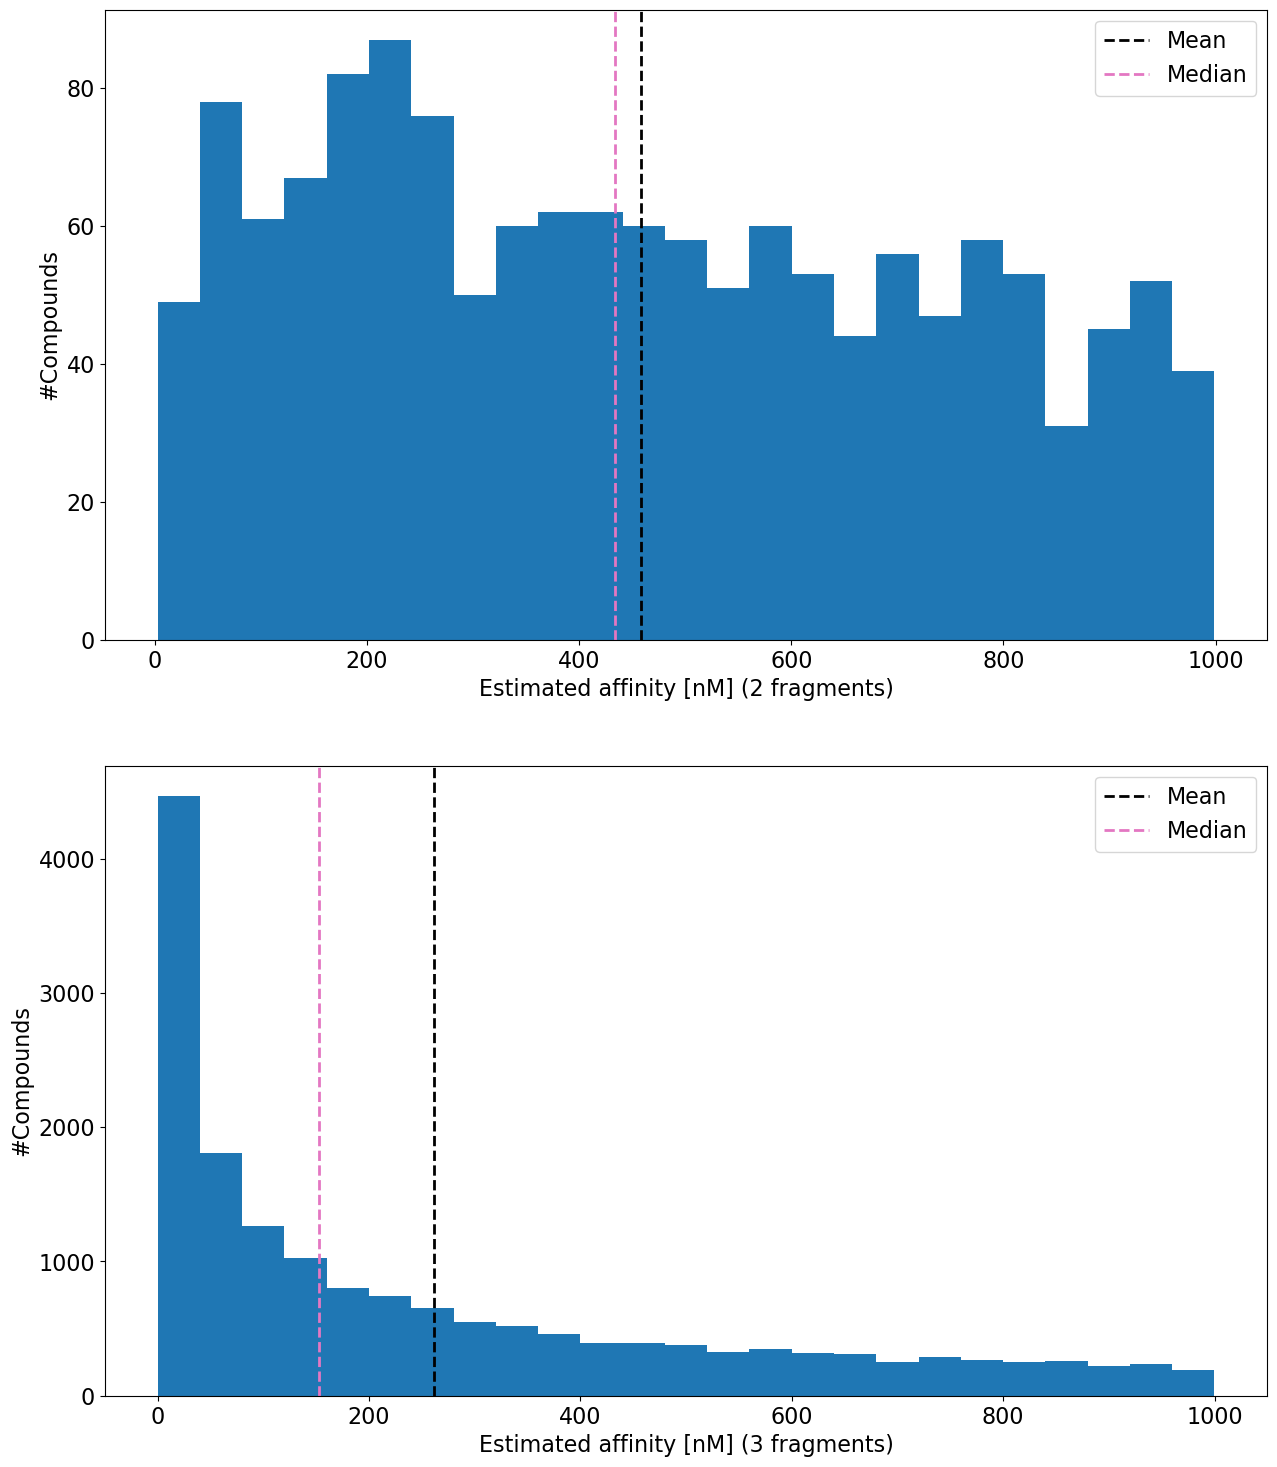

In [59]:
plt.rc('font', size=16) 
fig, axis = plt.subplots(2, 1, figsize=(15, 18))
descriptors = range(2, 4)
for i, descriptor_name in enumerate(descriptors):
        x = data_post_filtered[data_post_filtered.num_fragments == descriptor_name].binding_affinity
        axis[i].hist(x, bins=25)
        axis[i].set(ylabel="#Compounds", xlabel=f"Estimated affinity [nM] ({descriptor_name} fragments)")
        median_line = axis[i].axvline(x.median(), color='tab:pink', linestyle='dashed', linewidth=2, label="Median")
        line = axis[i].axvline(x.mean(), color='k', linestyle='dashed', linewidth=2, label = f"Mean")
        axis[i].legend(handles = [line, median_line], fontsize=16)

In [60]:
for descriptor_name in range(2, 4):
    x = data_post_filtered[data_post_filtered.num_fragments == descriptor_name].binding_affinity
    print(f"Median: {x.median()}")
    print(f'Binding Affinity stats. of compounds with {descriptor_name} fragments:\n{x.describe()}')

Median: 433.648523
Binding Affinity stats. of compounds with 2 fragments:
count    1441.000000
mean      458.042380
std       280.840965
min         2.827224
25%       211.359485
50%       433.648523
75%       693.311103
max       998.921803
Name: binding_affinity, dtype: float64
Median: 152.336384
Binding Affinity stats. of compounds with 3 fragments:
count    16717.000000
mean       261.957866
std        274.939608
min          0.021100
25%         35.477852
50%        152.336384
75%        423.396453
max        999.924213
Name: binding_affinity, dtype: float64


### Ro5 and Vebers properties

In [61]:
# HBD & HBA
data_post_filtered['HBD'] = data_post_filtered['ROMol'].apply(Lipinski.NumHDonors)
data_post_filtered['HBA'] = data_post_filtered['ROMol'].apply(Lipinski.NumHAcceptors)
# molecular weight
data_post_filtered['MW'] = data_post_filtered['ROMol'].apply(Descriptors.ExactMolWt)
#logP
data_post_filtered['logP'] = data_post_filtered['ROMol'].apply(Descriptors.MolLogP)
#rename tpsa
data_post_filtered['RB'] = data_post_filtered['ROMol'].apply(Descriptors.NumRotatableBonds)
data_post_filtered.rename(columns={'BIOSOLVEIT.TPSA': 'TPSA'}, inplace=True)

In [62]:
# rule of five fullfilled
data_post_filtered['Ro5'] = data_post_filtered.apply(lambda x: x.HBD <= 5 and x.HBA <= 10 and x.MW <= 500 and x.logP <= 5, axis=1)

# rule of five fullfilled
data_post_filtered['Veber'] = data_post_filtered.apply(lambda x: x.Ro5 and x.TPSA <= 140 and x.RB <= 5, axis=1)

# calculate QED
data_post_filtered['QED'] = data_post_filtered.apply(lambda x: QED.qed(x.ROMol), axis=1)

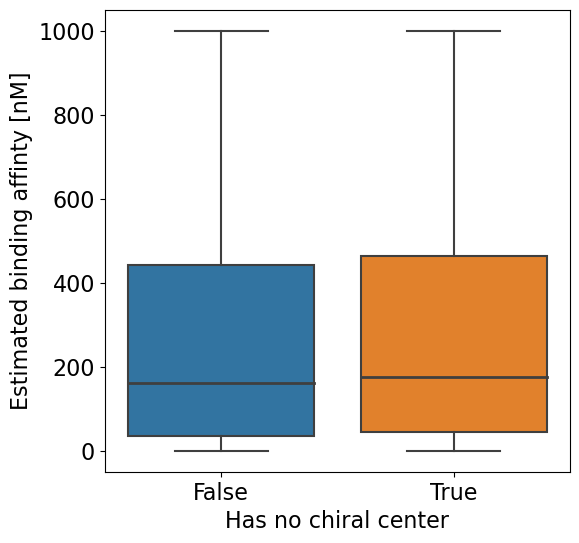

In [63]:
# binding affinity per subpocket
plt.figure(figsize=(6, 6))

sns.boxplot(
x="has_no_chiral_centre",
y='binding_affinity',
data=data_post_filtered,
medianprops={"linewidth": 2, "linestyle": "-"}
)
plt.ylabel("Estimated binding affinty [nM]", fontsize=16)
plt.xlabel("Has no chiral center", fontsize=16)
plt.show()

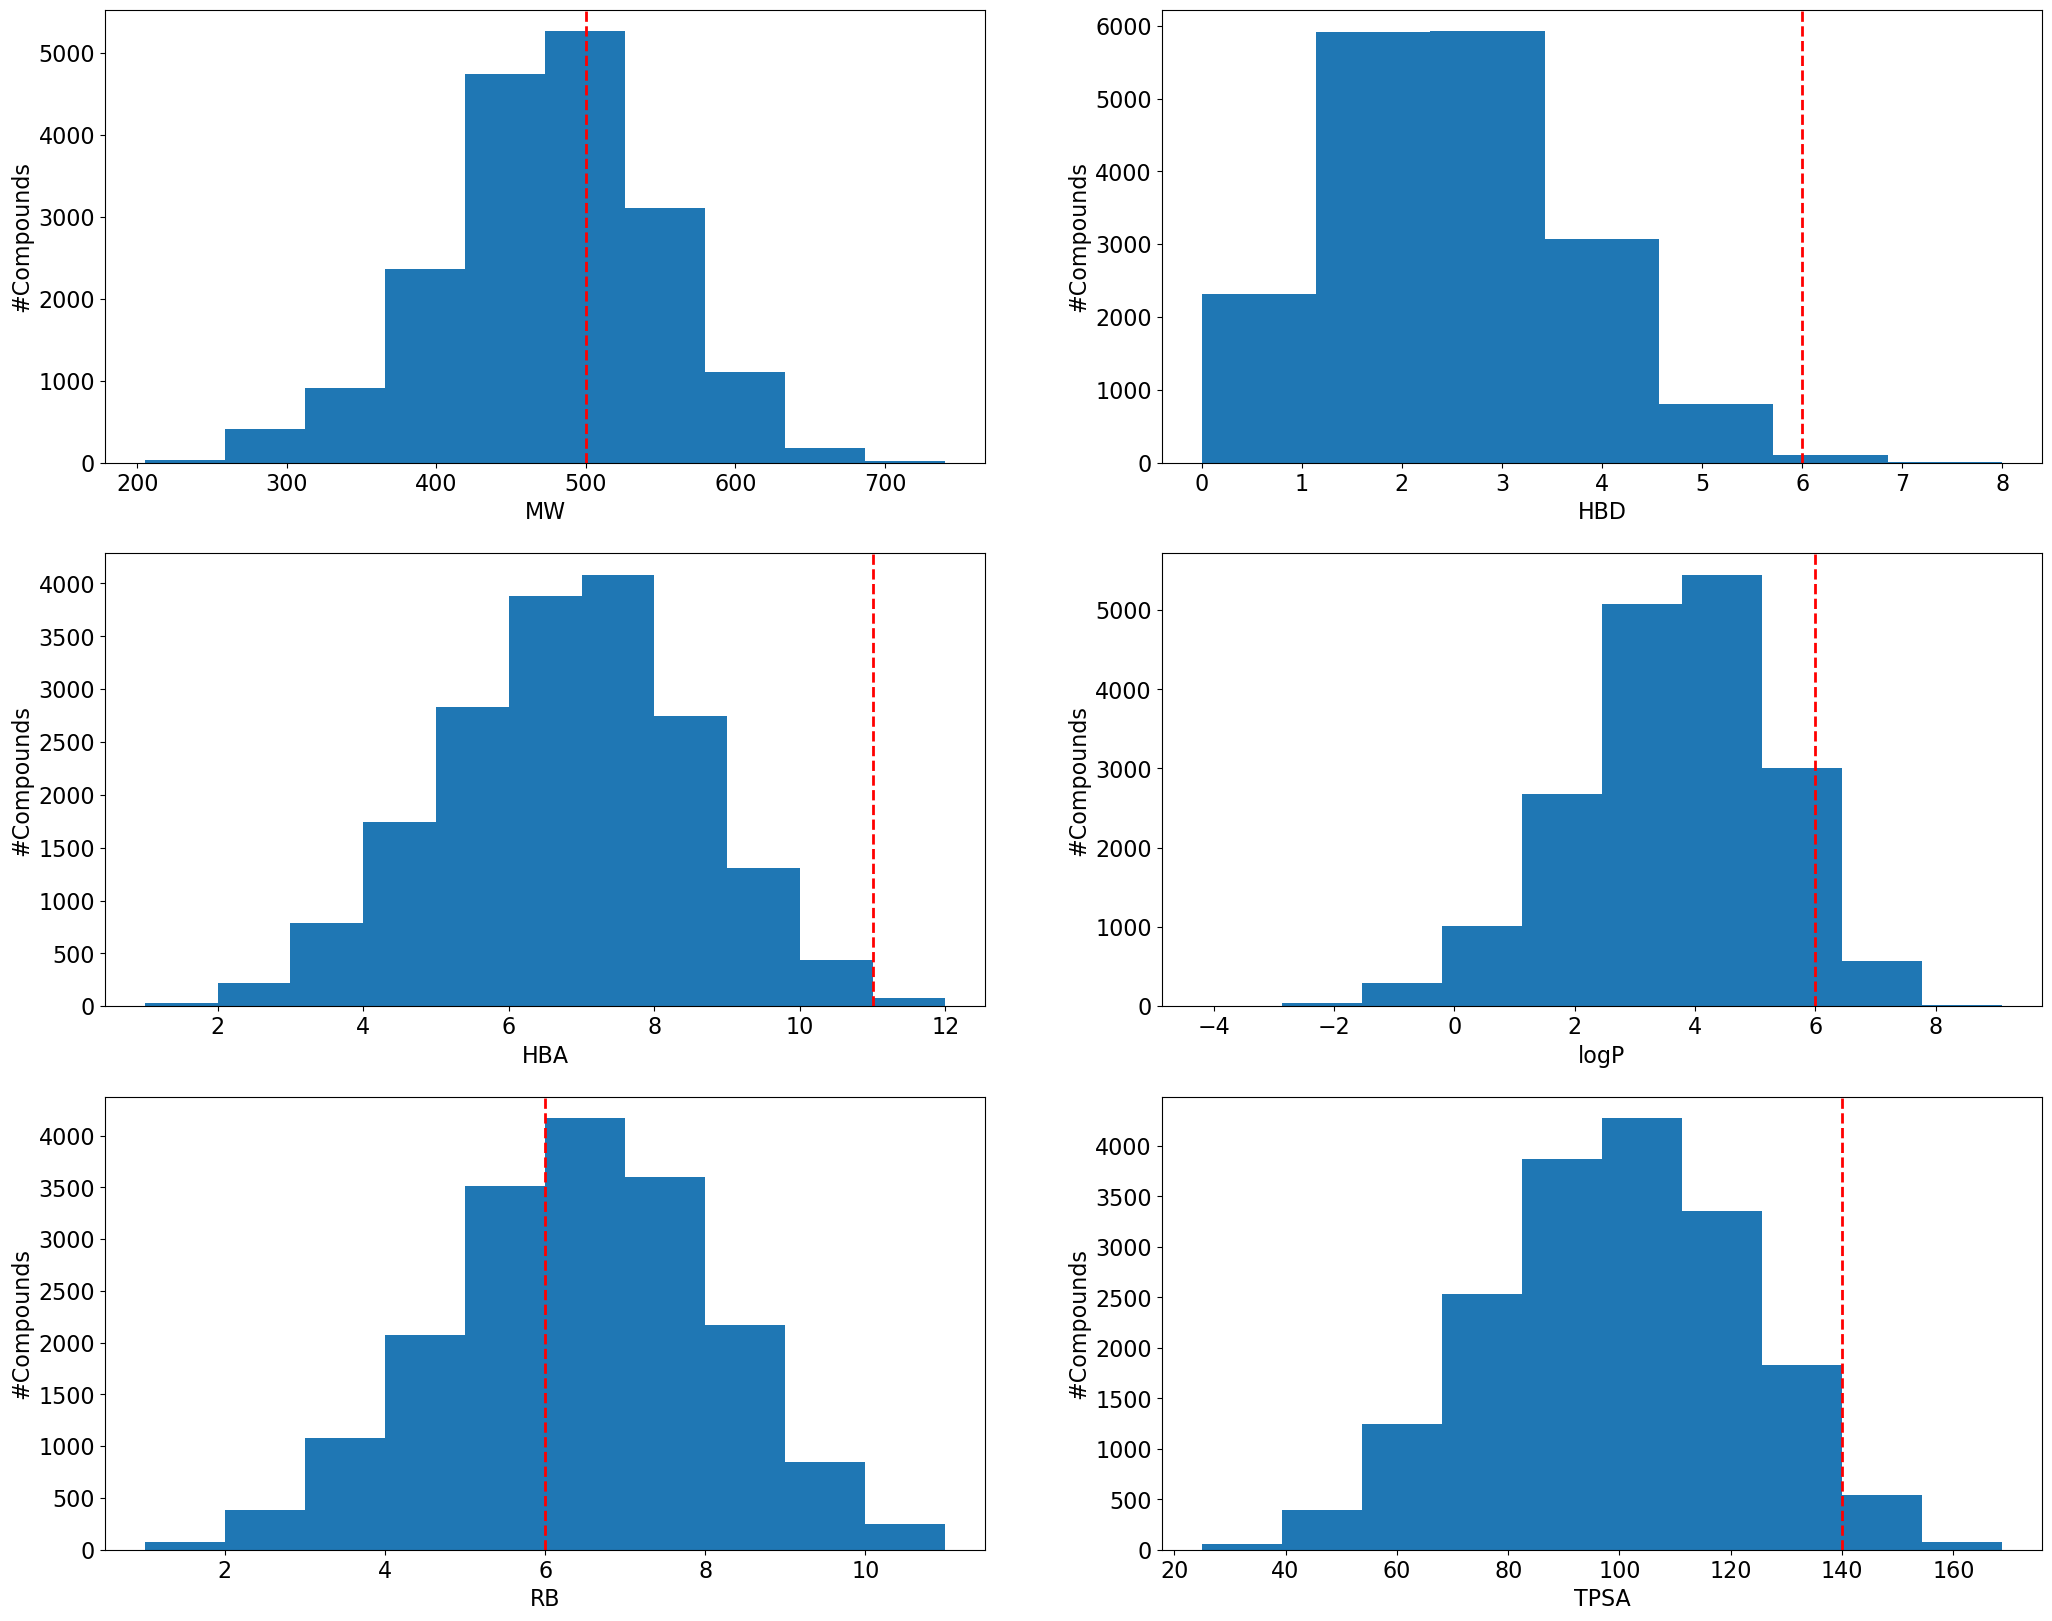

In [64]:
# plot Ro5 properties on reduced data
#plt.figure(figsize=(50, 6))
plt.rc('font', size=16) 
fig, axis = plt.subplots(3, 2)
fig.set_size_inches(25, 20)
descriptors = ['MW', 'HBD', 'HBA', 'logP', 'RB', 'TPSA']
_temp = ['g/mol', '', '', '', '', 'Å']
benchmarks = [500, 6, 11, 6, 6, 140]
labels = [500, 5, 10, 5, 5, 140]
for i, descriptor_name in enumerate(descriptors):
        if descriptor_name == 'HBD':
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name], bins=7)
        elif  descriptor_name == 'HBA': 
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name], bins=11)
        elif  descriptor_name == 'RB': 
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name], bins=10)
        else:
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name])
        axis[i // 2, i % 2].set(ylabel="#Compounds", xlabel=descriptor_name)
        line = axis[i // 2, i % 2].axvline(benchmarks[i], color='r', linestyle='dashed', linewidth=2, label = f"{labels[i]}{_temp[i]}")

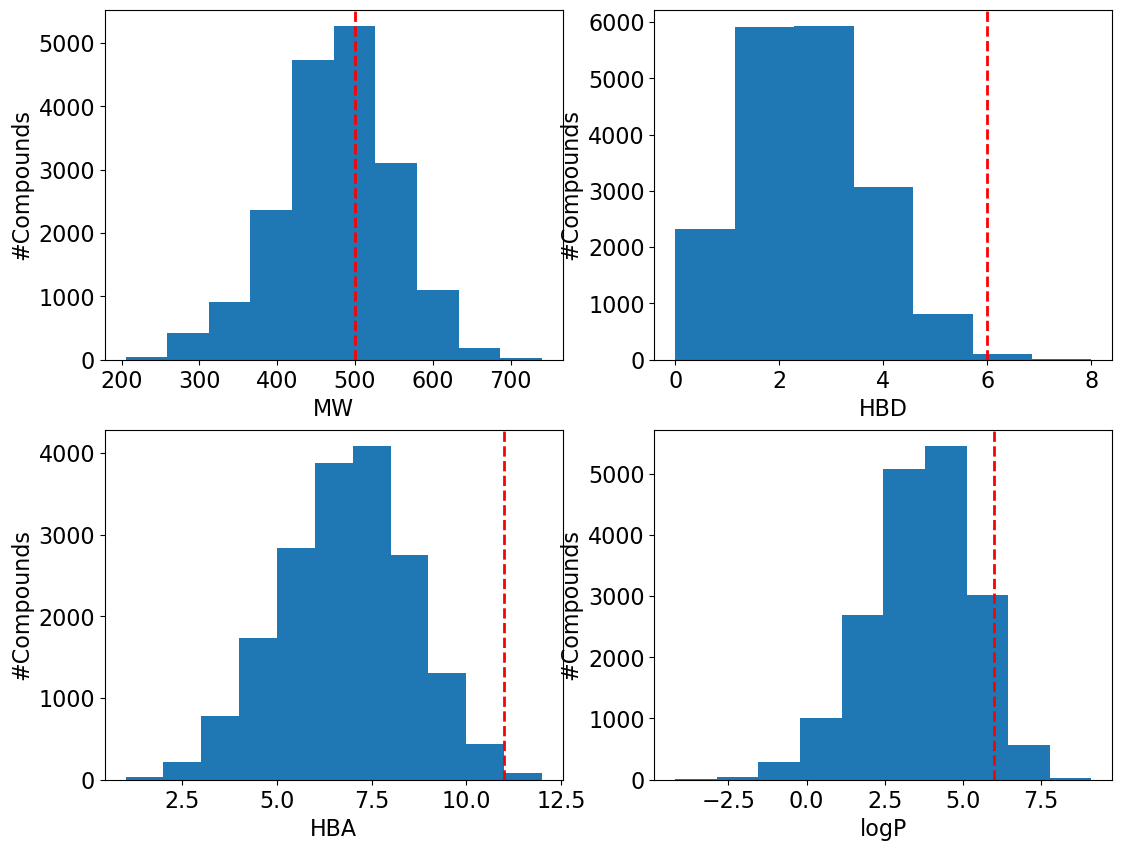

In [65]:
# plot Ro5 properties on reduced data
#plt.figure(figsize=(50, 6))
plt.rc('font', size=16) 
fig, axis = plt.subplots(2, 2)
fig.set_size_inches(13, 10)
descriptors = ['MW', 'HBD', 'HBA', 'logP']
_temp = ['g/mol', '', '', '', '', 'Å']
benchmarks = [500, 6, 11, 6]
labels = [500, 5, 10, 5]
for i, descriptor_name in enumerate(descriptors):
        if descriptor_name == 'HBD':
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name], bins=7)
        elif  descriptor_name == 'HBA': 
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name], bins=11)
        elif  descriptor_name == 'RB': 
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name], bins=12)
        else:
                axis[i // 2, i % 2].hist(data_post_filtered[descriptor_name])
        axis[i // 2, i % 2].set(ylabel="#Compounds", xlabel=descriptor_name)
        line = axis[i // 2, i % 2].axvline(benchmarks[i], color='r', linestyle='dashed', linewidth=2, label = f"{labels[i]}{_temp[i]}")

In [66]:
print(f'{sum(data_post_filtered["logP"] > 5)} compounds with logP > 5')
print(f'{sum(data_post_filtered["MW"] > 500)} compounds with MW > 500')
print(f'{sum(data_post_filtered["RB"] > 5)} compounds with RB > 5')
print(f'{sum(data_post_filtered["HBD"] > 5)} compounds with HBD > 5')
print(f'{sum(data_post_filtered["HBA"] > 10)} compounds with HBA > 10')
print(f'{sum(data_post_filtered["TPSA"] > 140)} compounds with TPSA > 140')

4016 compounds with logP > 5
6854 compounds with MW > 500
11029 compounds with RB > 5
113 compounds with HBD > 5
81 compounds with HBA > 10
621 compounds with TPSA > 140


In [67]:
# compounds fullfilling Ro5
print(f'{sum(data_post_filtered["Ro5"])} compounds fulfill Ro5')
print(f'{sum(data_post_filtered["Veber"])} compounds fulfill Vebers rule')
print(f'{sum(data_post_filtered[data_post_filtered["Veber"]]["Ro5"])} compounds fulfill Vebers rule & Ro5')

9193 compounds fulfill Ro5
4494 compounds fulfill Vebers rule
4494 compounds fulfill Vebers rule & Ro5


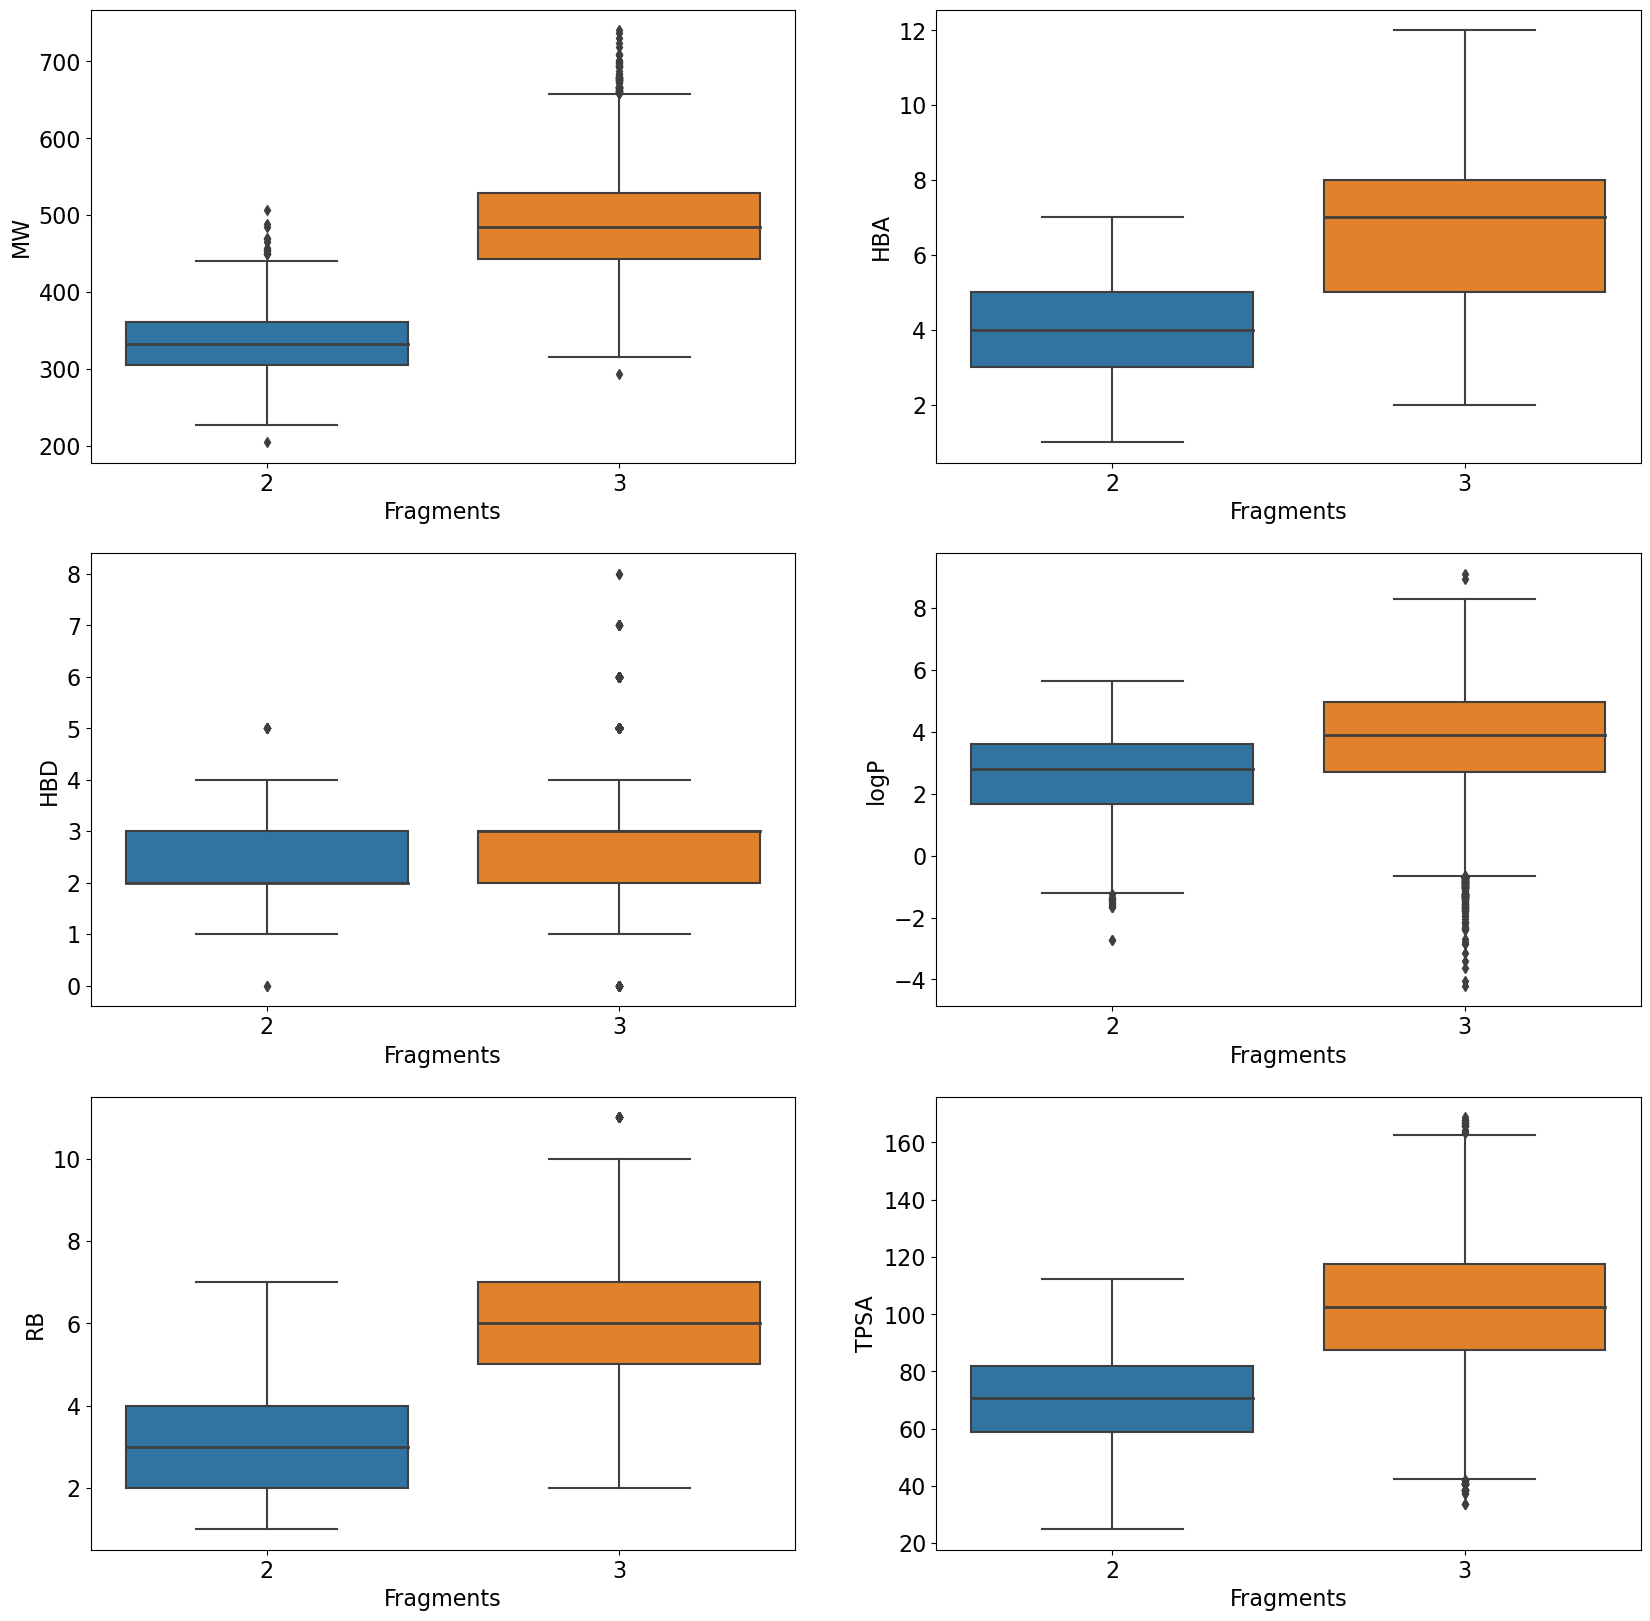

In [68]:
plt.figure(figsize=(20, 20))
descriptors = ['MW', 'HBA', 'HBD', 'logP', 'RB', 'TPSA']
for i, descriptor_name in enumerate(descriptors):
        plt.subplot(3, 2, i + 1)
        sns.boxplot(
        x="num_fragments",
        y=descriptor_name,
        data=data_post_filtered,
        medianprops={"linewidth": 2, "linestyle": "-"},
        )
        plt.ylabel(descriptor_name, fontsize=16)
        plt.xlabel("Fragments", fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

In [69]:
for descriptor_name in range(2, 4):
    x = data_post_filtered[data_post_filtered.num_fragments == descriptor_name].logP
    print(f'logP median of compounds with {descriptor_name} fragments:\n{x.mean()}')

logP median of compounds with 2 fragments:
2.562856849410133
logP median of compounds with 3 fragments:
3.7636912448405835


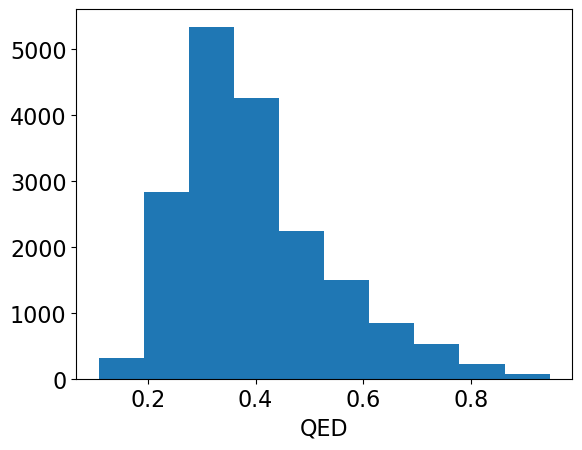

In [70]:
# plot QED
plt.hist(data_post_filtered['QED'])
plt.xlabel('QED')
plt.show()

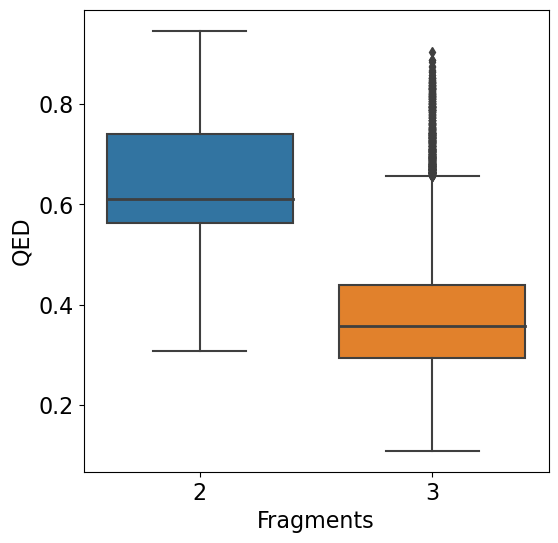

In [71]:
plt.figure(figsize=(6, 6))

descriptors = ['QED']
for i, descriptor_name in enumerate(descriptors):
        plt.subplot(1, 1, i + 1)
        sns.boxplot(
        x="num_fragments",
        y=descriptor_name,
        data=data_post_filtered,
        medianprops={"linewidth": 2, "linestyle": "-"},
        )
        plt.ylabel(descriptor_name, fontsize=16)
        plt.xlabel("Fragments", fontsize=16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)

Top 25 ranked compounds


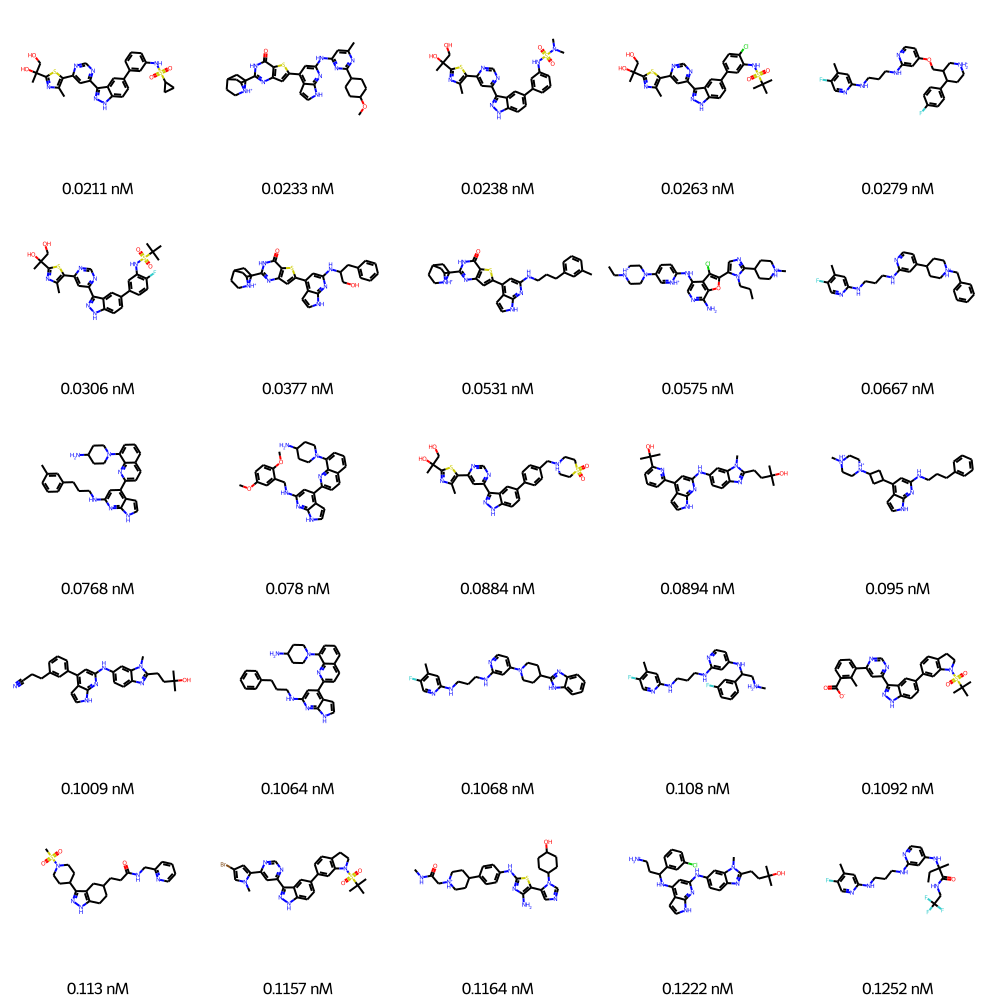

In [72]:
print("Top 25 ranked compounds")
mols = [data_post_filtered.ROMol[idx] for idx in range(25)]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols, 
    legends=[
        f"{round(data_post_filtered['binding_affinity'][idx],4)} nM"  
        for idx in range(25)
    ],  
    molsPerRow=5, 
    maxMols=100,
    subImgSize=(200, 200)
)
img

In [73]:
ro5fulfilled = data_post_filtered[data_post_filtered.Ro5].reset_index(drop=True)
ro5_veber_fulfilled = data_post_filtered[data_post_filtered.Veber].reset_index(drop=True)


Top 25 ranked compounds (fulfilling Ro5 and Vebers rule)


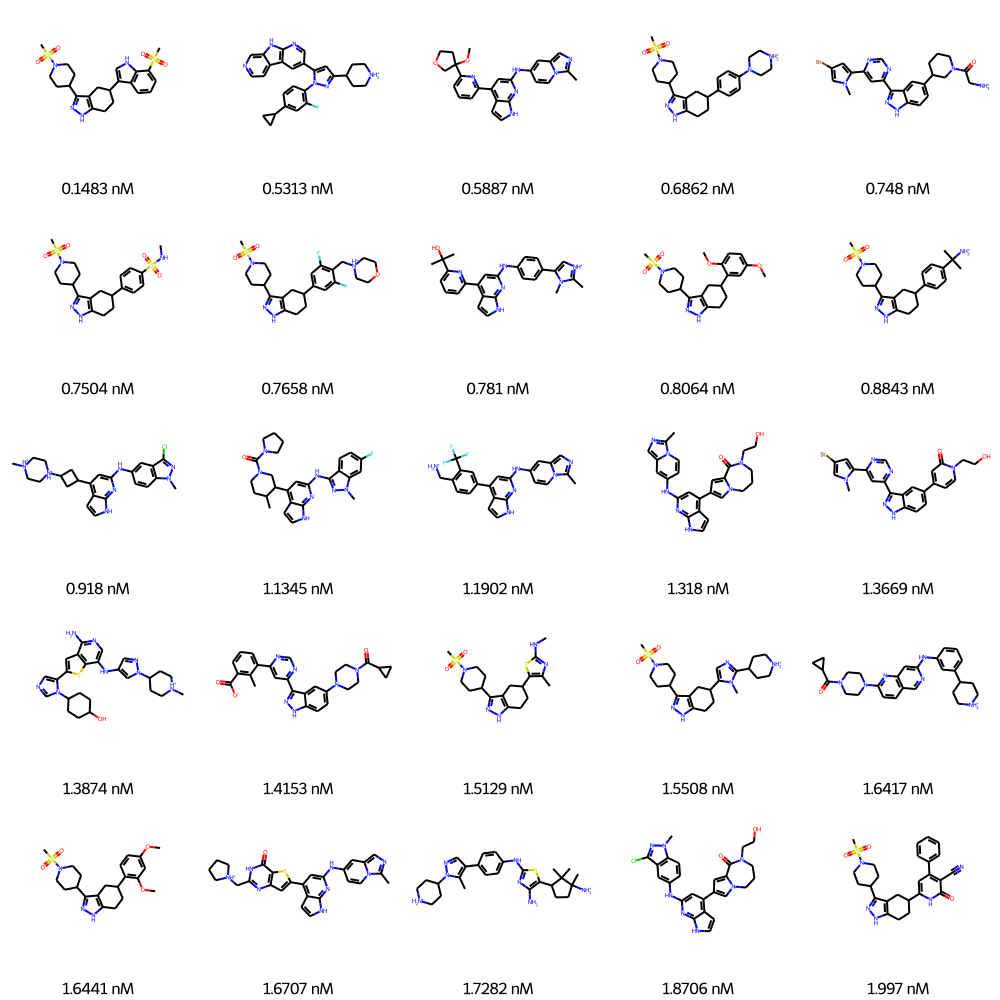

In [74]:
print("Top 25 ranked compounds (fulfilling Ro5 and Vebers rule)")
mols = [ro5_veber_fulfilled.ROMol[idx] for idx in range(25)]
for mol in mols:
    AllChem.Compute2DCoords(mol)
img = Draw.MolsToGridImage(
    mols,  
    molsPerRow=5, 
    legends=[f"{round(ro5_veber_fulfilled['binding_affinity'][idx],4)} nM" for idx in range(25)],
    maxMols=100,
    subImgSize=(200, 200)
)
img